In [3]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams

In [29]:
path = 'data.txt'
text = open(path).read().lower()
print('corpus length:', len(text))

corpus length: 402298


In [30]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(f'unique chars: {len(chars)}')

unique chars: 58


In [31]:
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print(f'num training examples: {len(sentences)}')

num training examples: 134086


In [37]:
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print(sentence[38])

o


In [38]:
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

In [40]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=5, shuffle=True).history

Train on 127381 samples, validate on 6705 samples
Epoch 1/5
127381/127381 [==============================] - 209s 2ms/step - loss: 1.8956 - accuracy: 0.4435 - val_loss: 2.2866 - val_accuracy: 0.3860
Epoch 2/5
127381/127381 [==============================] - 200s 2ms/step - loss: 1.6528 - accuracy: 0.5092 - val_loss: 2.2384 - val_accuracy: 0.4136
Epoch 3/5
127381/127381 [==============================] - 203s 2ms/step - loss: 1.5541 - accuracy: 0.5379 - val_loss: 2.2765 - val_accuracy: 0.3963
Epoch 4/5
127381/127381 [==============================] - 204s 2ms/step - loss: 1.4966 - accuracy: 0.5512 - val_loss: 2.2839 - val_accuracy: 0.4116
Epoch 5/5
127381/127381 [==============================] - 204s 2ms/step - loss: 1.4574 - accuracy: 0.5619 - val_loss: 2.3185 - val_accuracy: 0.4018


In [41]:
model.save('keras_model.h5')
pickle.dump(history, open("history.p", "wb"))

In [42]:
model = load_model('keras_model.h5')
history = pickle.load(open("history.p", "rb"))

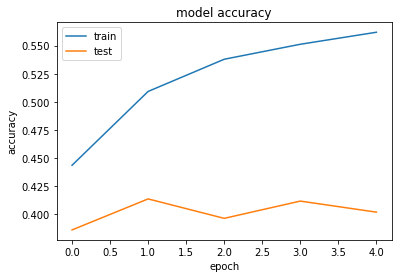

In [44]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

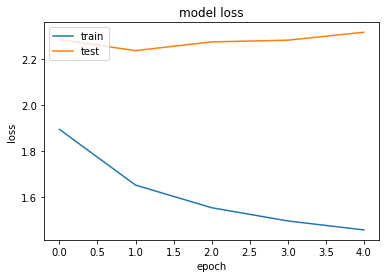

In [45]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [47]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [48]:
print(prepare_input("This is an example of input for our LSTM".lower()))


[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [49]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [50]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [51]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [52]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

it is not a lack of love, but a lack of 
['the ', 'such ', 'a ', 'manking ', 'his ']

that which does not kill us makes us str
['onger ', 'ight ', 'ange ', 'ength ', 'uggle ']

i'm not upset that you lied to me, i'm u
['nderstanding ', 'pperious ', 'sess ', 'riness ', 'ghout ']

and those who were seen dancing were tho
['ughts ', 'se ', 'o ', 're ', 'w ']

it is hard enough to remember my opinion
[' of ', ', ', '\nof ', 's ', '. ']

